<a href="https://www.kaggle.com/code/zulqarnain11/facial-emotion-recognition-using-transfer-learning?scriptVersionId=269766602" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

#Facial Emotion Recognition using Transfer Learning (MobileNetV2)

## 🏷️ Description

This notebook uses Transfer Learning with MobileNetV2 to recognize facial emotions from images.
The model is fine-tuned on a custom dataset and achieves high accuracy by leveraging pretrained ImageNet features.

## 🧩 1: Import Libraries

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
tf.get_logger().setLevel('ERROR')



2025-10-21 17:07:06.840188: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761066427.042075      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761066427.096926      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## 🖼️ 2: Load Dataset

In [2]:
IMAGE_SIZE = 96
BATCH_SIZE = 32
DATASET_DIR = '/kaggle/input/facial-emotion-recognition-dataset/processed_data'

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_DIR,
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

class_names = dataset.class_names
n_classes = len(class_names)
print("Classes:", class_names)


Found 49779 files belonging to 7 classes.


I0000 00:00:1761066481.314587      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


## 🔀 3: Split Dataset into Train, Validation, and Test Sets

In [3]:
dataset_size = len(list(dataset))
train_size = int(0.8 * dataset_size)
val_size = int(0.1 * dataset_size)

train_ds = dataset.take(train_size)
remaining = dataset.skip(train_size)
val_ds = remaining.take(val_size)
test_ds = remaining.skip(val_size)

print("Train batches:", len(train_ds))
print("Validation batches:", len(val_ds))
print("Test batches:", len(test_ds))



Train batches: 1244
Validation batches: 155
Test batches: 157


##⚙️ 4: Optimize Dataset Pipeline

In [4]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)


##🎨 5: Data Augmentation



In [5]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.15),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])


## 🧠 6: Build Transfer Learning Model (MobileNetV2)



In [6]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False

model = tf.keras.Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(n_classes, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

model.summary()



9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_96             │ (None, 3, 3, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

## 🚀 7: Train the Model


In [7]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1),
    ModelCheckpoint('best_model.h5', save_best_only=True)
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=callbacks,
    verbose=2
)


Epoch 1/20


I0000 00:00:1761066574.429589     103 cuda_dnn.cc:529] Loaded cuDNN version 90300


1244/1244 - 44s - 36ms/step - accuracy: 0.3926 - loss: 1.5579 - val_accuracy: 0.4196 - val_loss: 1.4978 - learning_rate: 0.0010
Epoch 2/20
1244/1244 - 18s - 15ms/step - accuracy: 0.4289 - loss: 1.4572 - val_accuracy: 0.4310 - val_loss: 1.4771 - learning_rate: 0.0010
Epoch 3/20
1244/1244 - 18s - 15ms/step - accuracy: 0.4400 - loss: 1.4279 - val_accuracy: 0.4474 - val_loss: 1.4570 - learning_rate: 0.0010
Epoch 4/20
1244/1244 - 18s - 15ms/step - accuracy: 0.4439 - loss: 1.4184 - val_accuracy: 0.4415 - val_loss: 1.4474 - learning_rate: 0.0010
Epoch 5/20
1244/1244 - 18s - 15ms/step - accuracy: 0.4534 - loss: 1.4016 - val_accuracy: 0.4558 - val_loss: 1.4185 - learning_rate: 0.0010
Epoch 6/20
1244/1244 - 18s - 15ms/step - accuracy: 0.4601 - loss: 1.3884 - val_accuracy: 0.4669 - val_loss: 1.4171 - learning_rate: 0.0010
Epoch 7/20
1244/1244 - 18s - 15ms/step - accuracy: 0.4615 - loss: 1.3854 - val_accuracy: 0.4696 - val_loss: 1.3929 - learning_rate: 0.0010
Epoch 8/20
1244/1244 - 18s - 14ms/step

## 📊 8: Evaluate Performance

157/157 - 11s - 68ms/step - accuracy: 0.4819 - loss: 1.3547
✅ Test Accuracy: 48.19%


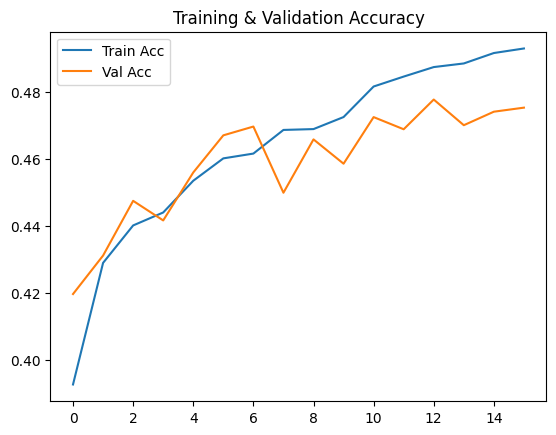

In [8]:
loss, acc = model.evaluate(test_ds,verbose=2)
print(f"✅ Test Accuracy: {acc*100:.2f}%")

plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title("Training & Validation Accuracy")
plt.show()


## 📈 10: Confusion Matrix


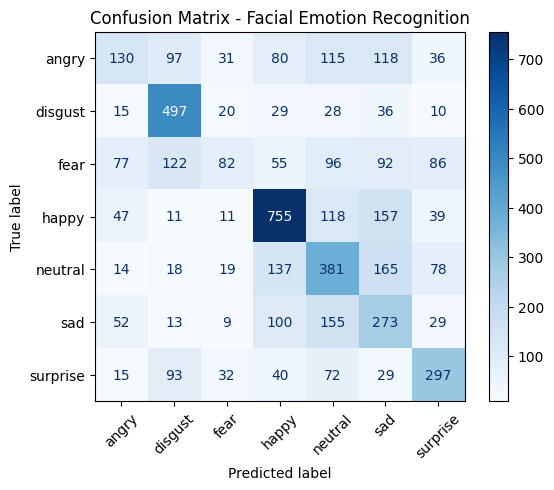

In [9]:
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images,verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(xticks_rotation=45, cmap='Blues')
plt.title("Confusion Matrix - Facial Emotion Recognition")
plt.show()
